# **Classifying Cats or Dogs using Transfer Learning**
  In this notebook,we will classify cats or dogs using a Pretrained MobileNet model.

Install the required Packages!

In [1]:
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 4.2 MB/s 
     |████████████████████████████████| 98 kB 8.0 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


Import the necessary Packages that are required

In [2]:
import time
import numpy as np
import matplotlib.pylab as plt
import os

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import tempfile
from gc import callbacks
from tensorflow.keras.utils import plot_model
import os
import time
from PIL import Image
import PIL.Image
import pandas as pd
from sklearn.metrics import accuracy_score
from google.colab import files

from tensorflow.keras import layers

**Loading the datasets**


Load the data and split it into train and validation sets!!

In [3]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'),
    with_info = True,
    as_supervised = True
)

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
# Get the class names
num_classes = info.features["label"].num_classes
class_names = info.features["label"].names
num_classes, class_names

(2, ['cat', 'dog'])

# **Preprocessing the data**

In [5]:
def format_image(image, label):
  image = tf.image.resize(image, IMG_SIZE)/255.0
  return image,label

num_examples = info.splits['train'].num_examples

BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_batches = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

To use a pretrained model,we should install the tensorflow-hub package,in this we are going to use Google's mobilenet for getting better results

In [6]:
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Ge the MobileNet pretrained layer!**

In [7]:
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE + (3,)), include_top=False)

9420800/9406464 [==============================] - 0s 0us/step


In [8]:
feature_extractor.trainable = False

Train the pretrained model!!,just change the output layer,in this we are classifying cats vs dogs, as it is a binary classification,there are only two output layers

In [9]:
model = tf.keras.Sequential([
                             feature_extractor,
                             tf.keras.layers.GlobalMaxPooling2D(),
                             layers.Dense(2, activation="softmax")                           
], name="cats_vs_dogs")
model.summary()

Model: "cats_vs_dogs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# **Compile the model**


In [10]:
# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0,
                                            save_best_only=True)

In [11]:
model.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
EPOCHS = 5
history = model.fit(train_batches,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data = validation_batches,
                    callbacks=[create_model_checkpoint(model_name=model.name)])

Epoch 1/5
1164/1164 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9663

INFO:tensorflow:Assets written to: model_experiments/cats_vs_dogs/assets


INFO:tensorflow:Assets written to: model_experiments/cats_vs_dogs/assets


1164/1164 [==============================] - 73s 49ms/step - loss: 0.1359 - accuracy: 0.9663 - val_loss: 0.0975 - val_accuracy: 0.9783
Epoch 2/5
1164/1164 [==============================] - 26s 22ms/step - loss: 0.1044 - accuracy: 0.9787 - val_loss: 0.3652 - val_accuracy: 0.9475
Epoch 3/5
1164/1164 [==============================] - 28s 24ms/step - loss: 0.1054 - accuracy: 0.9809 - val_loss: 0.1404 - val_accuracy: 0.9753
Epoch 4/5
1164/1164 [==============================] - 26s 22ms/step - loss: 0.0901 - accuracy: 0.9818 - val_loss: 0.1024 - val_accuracy: 0.9815
Epoch 5/5
1164/1164 [==============================] - 26s 22ms/step - loss: 0.0818 - accuracy: 0.9847 - val_loss: 0.2101 - val_accuracy: 0.9708


We can see that it has a nearly 99% accuracy on validation examples

In [12]:
feature_extractor.trainable = True

In [13]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(feature_extractor.layers))

# Fine-tune from this layer onwards
fine_tune_at = 30

# Freeze all the layers before the `fine_tune_at` layer
for layer in feature_extractor.layers[:-fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [14]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [15]:
EPOCHS = 3
history = model.fit(train_batches,
                    epochs = EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data = validation_batches,
                    callbacks=[create_model_checkpoint(model_name=model.name)])

Epoch 1/3
1164/1164 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.9589

INFO:tensorflow:Assets written to: model_experiments/cats_vs_dogs/assets


INFO:tensorflow:Assets written to: model_experiments/cats_vs_dogs/assets


1164/1164 [==============================] - 58s 46ms/step - loss: 0.2733 - accuracy: 0.9589 - val_loss: 0.1570 - val_accuracy: 0.9776
Epoch 2/3
1162/1164 [============================>.] - ETA: 0s - loss: 0.1077 - accuracy: 0.9802

INFO:tensorflow:Assets written to: model_experiments/cats_vs_dogs/assets


INFO:tensorflow:Assets written to: model_experiments/cats_vs_dogs/assets


1164/1164 [==============================] - 52s 45ms/step - loss: 0.1078 - accuracy: 0.9802 - val_loss: 0.1339 - val_accuracy: 0.9791
Epoch 3/3
1164/1164 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9850

INFO:tensorflow:Assets written to: model_experiments/cats_vs_dogs/assets


INFO:tensorflow:Assets written to: model_experiments/cats_vs_dogs/assets


1164/1164 [==============================] - 52s 45ms/step - loss: 0.0683 - accuracy: 0.9850 - val_loss: 0.1183 - val_accuracy: 0.9791


# Save the model

Save the model in h5 format to use it later!!

In [16]:
# Load in the best saved model
model_1 = tf.keras.models.load_model("/content/model_experiments/cats_vs_dogs")

In [42]:
model_1.evaluate(validation_batches)

291/291 [==============================] - 7s 23ms/step - loss: 0.1183 - accuracy: 0.9791


[0.1182503029704094, 0.9791487455368042]

# Saving the model in .h5 format
Save the trained reloaded model,to export it later

In [43]:
model_1.save("cats_vs_dogs_ft.h5")

## Unzip the testing (100 images) data for benchmarking

In [19]:
# Get the data
!wget https://github.com/SanK89/cats-vs-dogs-classification-using-transfer-learning/raw/main/cats_vs_dogs.zip

--2022-07-10 08:46:50--  https://github.com/SanK89/cats-vs-dogs-classification-using-transfer-learning/raw/main/cats_vs_dogs.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SanK89/cats-vs-dogs-classification-using-transfer-learning/main/cats_vs_dogs.zip [following]
--2022-07-10 08:46:51--  https://raw.githubusercontent.com/SanK89/cats-vs-dogs-classification-using-transfer-learning/main/cats_vs_dogs.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2189689 (2.1M) [application/zip]
Saving to: ‘cats_vs_dogs.zip.1’

cats_vs_dogs.zip.1  100%[===================>]   2.09M  --.-KB/s    in 0.07s  

In [20]:
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/cats_vs_dogs.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [21]:
benchmark_dir = "/content/cats_vs_dogs"

In [22]:
val_data = tf.keras.utils.image_dataset_from_directory(directory=benchmark_dir,
                                              #color_mode="grayscale",
                                              image_size=IMG_SIZE,
                                              batch_size=BATCH_SIZE,
                                              label_mode="int")

Found 100 files belonging to 2 classes.


In [23]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

In [24]:
val_data = val_data.map(normalize_img)
val_data

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Benchmark Accuracy

In [25]:
print(f"The Accuracy of the validation data {model_1.evaluate(val_data)[1] * 100:.2f}%")

7/7 [==============================] - 1s 33ms/step - loss: 0.0739 - accuracy: 0.9900
The Accuracy of the validation data 99.00%


In [45]:
baseline_score = model_1.evaluate(validation_batches)
print(f"The accuracy of the baseline model is {baseline_score[1] * 100:.2f} %")
base_metrics = {
      "sparsity" : 0,
      "val_loss" : np.round(baseline_score[0], 4),
      "val_accuracy" : np.round(baseline_score[1] * 100, 4)
}
base_metrics

291/291 [==============================] - 6s 21ms/step - loss: 0.1183 - accuracy: 0.9791
The accuracy of the baseline model is 97.91 %


{'sparsity': 0, 'val_accuracy': 97.9149, 'val_loss': 0.1183}

### Function to read in benchmarking images

In [26]:
# Function to infer the val images 
import numpy as np
import os
import time
from PIL import Image
import PIL.Image

def benchmark(val_dir, model, class_names=class_names, image_size=IMG_SIZE):
  file_count = 0
  infer_times = []
  for (root, dirs, files) in os.walk(val_dir):
    for name in files:
      if name.endswith(".jpg"):
        filename = os.path.join(root, name)
        if file_count < 1 :
          init_timer_start = time.time()
          img = np.array(Image.open(filename).resize(IMG_SIZE))/255.
          pred = model.predict(np.expand_dims(img, axis=0))
          pred_class = class_names[int(np.argmax(pred[0]))]
          init_timer_end = time.time()
          init_timer = init_timer_end - init_timer_start
          file_count+=1
        else:
          timer_start = time.time()
          img = np.array(Image.open(filename).resize(IMG_SIZE))/255.
          pred = model.predict(np.expand_dims(img, axis=0))
          pred_class = class_names[int(np.argmax(pred[0]))]
          timer_end = time.time()
          infer_times.append((timer_end - timer_start))
          file_count+=1

  return init_timer, np.mean(infer_times), np.std(infer_times)

In [27]:
init_time, avg_time, std = benchmark(val_dir=benchmark_dir,
          model=model_1)
print(f"The first image takes {init_time * 1000:.2f} ms")
print(f"The average time taken per 99 images {avg_time * 1000:.2f} ms")
print(f"The standard deviation of samples is {std * 1000:.2f} ms")

The first image takes 1026.41 ms
The average time taken per 99 images 64.16 ms
The standard deviation of samples is 3.40 ms


## Pruning

### Results form the baseline model

In [ ]:
_, baseline_accuracy = model_1.evaluate(validation_batches)
print(f"The accuracy of the baseline model is {baseline_accuracy * 100:.2f} %")

291/291 [==============================] - 7s 23ms/step - loss: 0.3930 - accuracy: 0.8702
The accuracy of the baseline model is 87.02 %


### Prunig the layers

In [41]:
!pip install tensorflow_model_optimization 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 237 kB 4.1 MB/s 


In [44]:
import tensorflow_model_optimization as tfmot

# Finish pruning after 2 epochs
epochs = 2
BATCH_SIZE = 16
print(len(validation_batches))

291


In [55]:
from tensorflow_model_optimization.python.core.keras import metrics
def prune_model(model, initial_sparsity, final_sparsity, train_data=train_batches, val_data=validation_batches, epochs=epochs ):
  # Create a tensorboard logfile
  logdir = tempfile.mkdtemp()
  # The end_step is the total number of iterations required for the training data which is basically the entire epochs over the length of the training data
  end_step = int(len(train_data) * epochs * 0.5)
  # Import the low-magnitude-pruning function
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
  # Set the prunung params
  pruning_params = {
      
      "pruning_schedule" : tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                                final_sparsity=final_sparsity,
                                                                begin_step=0,
                                                                end_step=end_step)
      
                  }

  
  learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    0.001,
    1000,
    0.0001,
    power=0.5)
  
  # Model for pruning
  model_for_pruning = prune_low_magnitude(model, **pruning_params)

  # Recompile
  model_for_pruning.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                            metrics=["accuracy"])
  #create callbacks
  callbacks = [tfmot.sparsity.keras.UpdatePruningStep(),
              tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
               #create_model_checkpoint(model_name=model.name),
              tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                  patience=3,
                                                  verbose=1),
               #tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        #patience=5,
                                                        #restore_best_weights=True)
                                                        ]
  
  # Fit the model
  model_for_pruning.fit(train_data,
                      validation_data=val_data,
                      batch_size=BATCH_SIZE,
                      epochs=epochs,
                      callbacks=callbacks)
  
  # Save the model
  #model_for_pruning.save(f"mnist_model_sparsity_{final_sparsity}")

  # Evaluate the model
  score = model_for_pruning.evaluate(val_data, verbose=0)
  metric_dict = {
      "sparsity" : final_sparsity,
      "val_loss" : np.round(score[0], 4),
      "val_accuracy" : np.round(score[1] * 100, 4)
  }
  return logdir, metric_dict, model_for_pruning

In [56]:
k_sparsities = [0.25, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.97, 0.99]

#k_sparsities = [0.50]
metric_list = []
for k in k_sparsities:
  logdir, metrics, pruned_model = prune_model(model=model_1,
            initial_sparsity=0,
            final_sparsity=k,
            epochs=20)
  val_loss, val_accuracy  = metrics["val_loss"], metrics["val_accuracy"]
  metric_list.append(metrics)
  print(f"Sparsity : {k} \tValidation Loss: {val_loss}, \tValidation Accuracy: {val_accuracy}")

# Create a dataframe of the values obtained
df = pd.DataFrame(metric_list)

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


Epoch 1/20
   6/1164 [..............................] - ETA: 1:19 - loss: 0.3373 - accuracy: 0.9583WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0609s vs `on_train_batch_end` time: 0.1921s). Check your callbacks.


1164/1164 [==============================] - 134s 80ms/step - loss: 0.1066 - accuracy: 0.9750 - val_loss: 0.3564 - val_accuracy: 0.9456 - lr: 0.0010
Epoch 2/20
1164/1164 [==============================] - 87s 74ms/step - loss: 0.0950 - accuracy: 0.9763 - val_loss: 0.2432 - val_accuracy: 0.9387 - lr: 0.0010
Epoch 3/20
1164/1164 [==============================] - 87s 74ms/step - loss: 0.0864 - accuracy: 0.9761 - val_loss: 0.1475 - val_accuracy: 0.9506 - lr: 0.0010
Epoch 4/20
1164/1164 [==============================] - 91s 78ms/step - loss: 0.0515 - accuracy: 0.9876 - val_loss: 0.1974 - val_accuracy: 0.9540 - lr: 0.0010
Epoch 5/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.0455 - accuracy: 0.9893 - val_loss: 0.2315 - val_accuracy: 0.9484 - lr: 0.0010
Epoch 6/20
1164/1164 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9877
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1164/1164 [=============================

1164/1164 [==============================] - 131s 77ms/step - loss: 0.0445 - accuracy: 0.9889 - val_loss: 0.2234 - val_accuracy: 0.9473 - lr: 0.0010
Epoch 2/20
1164/1164 [==============================] - 87s 75ms/step - loss: 0.0263 - accuracy: 0.9921 - val_loss: 0.2359 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 3/20
1164/1164 [==============================] - 87s 75ms/step - loss: 0.0366 - accuracy: 0.9912 - val_loss: 0.1732 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 4/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.0169 - accuracy: 0.9942 - val_loss: 0.1932 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 5/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.0280 - accuracy: 0.9938 - val_loss: 0.3458 - val_accuracy: 0.9353 - lr: 0.0010
Epoch 6/20
1164/1164 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9893
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1164/1164 [=============================

1164/1164 [==============================] - 129s 76ms/step - loss: 0.1913 - accuracy: 0.9376 - val_loss: 0.4315 - val_accuracy: 0.9009 - lr: 0.0010
Epoch 2/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.1756 - accuracy: 0.9477 - val_loss: 0.3676 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 3/20
1164/1164 [==============================] - 91s 78ms/step - loss: 0.0941 - accuracy: 0.9655 - val_loss: 0.2734 - val_accuracy: 0.9273 - lr: 0.0010
Epoch 4/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.0799 - accuracy: 0.9729 - val_loss: 0.2598 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 5/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.1049 - accuracy: 0.9629 - val_loss: 0.4586 - val_accuracy: 0.8287 - lr: 0.0010
Epoch 6/20
1164/1164 [==============================] - 91s 78ms/step - loss: 0.2819 - accuracy: 0.8902 - val_loss: 0.7342 - val_accuracy: 0.5944 - lr: 0.0010
Epoch 7/20
1164/1164 [==============================] - 

1164/1164 [==============================] - 128s 76ms/step - loss: 0.3226 - accuracy: 0.8807 - val_loss: 0.2589 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 2/20
1164/1164 [==============================] - 92s 79ms/step - loss: 0.2192 - accuracy: 0.9135 - val_loss: 0.3578 - val_accuracy: 0.8809 - lr: 0.0010
Epoch 3/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.1819 - accuracy: 0.9289 - val_loss: 0.2861 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 4/20
1164/1164 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9415
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1164/1164 [==============================] - 86s 74ms/step - loss: 0.1523 - accuracy: 0.9415 - val_loss: 0.2676 - val_accuracy: 0.8936 - lr: 0.0010
Epoch 5/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.1153 - accuracy: 0.9552 - val_loss: 0.5606 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 6/20
1164/1164 [=========================

1164/1164 [==============================] - 134s 80ms/step - loss: 0.4352 - accuracy: 0.8220 - val_loss: 0.4424 - val_accuracy: 0.8065 - lr: 0.0010
Epoch 2/20
1164/1164 [==============================] - 91s 78ms/step - loss: 0.2963 - accuracy: 0.8775 - val_loss: 0.3059 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 3/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.2386 - accuracy: 0.9032 - val_loss: 0.2746 - val_accuracy: 0.8826 - lr: 0.0010
Epoch 4/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.2113 - accuracy: 0.9138 - val_loss: 0.2594 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 5/20
1164/1164 [==============================] - 91s 78ms/step - loss: 0.1899 - accuracy: 0.9239 - val_loss: 0.2754 - val_accuracy: 0.8874 - lr: 0.0010
Epoch 6/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.4036 - accuracy: 0.8195 - val_loss: 0.7712 - val_accuracy: 0.5146 - lr: 0.0010
Epoch 7/20
1164/1164 [==============================] - 

1164/1164 [==============================] - 128s 76ms/step - loss: 0.4588 - accuracy: 0.7941 - val_loss: 0.6106 - val_accuracy: 0.7790 - lr: 0.0010
Epoch 2/20
1164/1164 [==============================] - 91s 78ms/step - loss: 0.4123 - accuracy: 0.8274 - val_loss: 0.3416 - val_accuracy: 0.8446 - lr: 0.0010
Epoch 3/20
1164/1164 [==============================] - 85s 73ms/step - loss: 0.3325 - accuracy: 0.8554 - val_loss: 0.3352 - val_accuracy: 0.8495 - lr: 0.0010
Epoch 4/20
1164/1164 [==============================] - 90s 78ms/step - loss: 0.3025 - accuracy: 0.8722 - val_loss: 0.3648 - val_accuracy: 0.8295 - lr: 0.0010
Epoch 5/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.2923 - accuracy: 0.8768 - val_loss: 0.3313 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 6/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.5072 - accuracy: 0.7423 - val_loss: 0.8756 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 7/20
1164/1164 [==============================] - 

1164/1164 [==============================] - 130s 78ms/step - loss: 0.6620 - accuracy: 0.6674 - val_loss: 1.1760 - val_accuracy: 0.5252 - lr: 0.0010
Epoch 2/20
1164/1164 [==============================] - 84s 72ms/step - loss: 0.5709 - accuracy: 0.7117 - val_loss: 0.9027 - val_accuracy: 0.5533 - lr: 0.0010
Epoch 3/20
1164/1164 [==============================] - 84s 72ms/step - loss: 0.5375 - accuracy: 0.7321 - val_loss: 0.6593 - val_accuracy: 0.6303 - lr: 0.0010
Epoch 4/20
1164/1164 [==============================] - 84s 72ms/step - loss: 0.5214 - accuracy: 0.7418 - val_loss: 0.8366 - val_accuracy: 0.5656 - lr: 0.0010
Epoch 5/20
1164/1164 [==============================] - 85s 73ms/step - loss: 0.4991 - accuracy: 0.7554 - val_loss: 1.3384 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 6/20
1164/1164 [==============================] - ETA: 0s - loss: 0.4945 - accuracy: 0.7597
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1164/1164 [=============================

1164/1164 [==============================] - 131s 79ms/step - loss: 0.7246 - accuracy: 0.6139 - val_loss: 0.9235 - val_accuracy: 0.5123 - lr: 0.0010
Epoch 2/20
1164/1164 [==============================] - 85s 73ms/step - loss: 0.6526 - accuracy: 0.6556 - val_loss: 0.9520 - val_accuracy: 0.4901 - lr: 0.0010
Epoch 3/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.5995 - accuracy: 0.6878 - val_loss: 0.5738 - val_accuracy: 0.6963 - lr: 0.0010
Epoch 4/20
1164/1164 [==============================] - 85s 73ms/step - loss: 0.5688 - accuracy: 0.7039 - val_loss: 0.5504 - val_accuracy: 0.7218 - lr: 0.0010
Epoch 5/20
1164/1164 [==============================] - 90s 78ms/step - loss: 0.5533 - accuracy: 0.7173 - val_loss: 0.5889 - val_accuracy: 0.6930 - lr: 0.0010
Epoch 6/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.5425 - accuracy: 0.7256 - val_loss: 0.6438 - val_accuracy: 0.6023 - lr: 0.0010
Epoch 7/20
1164/1164 [==============================] - 

1164/1164 [==============================] - 133s 80ms/step - loss: 0.7389 - accuracy: 0.5801 - val_loss: 1.0018 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 2/20
1164/1164 [==============================] - 87s 74ms/step - loss: 0.6322 - accuracy: 0.6472 - val_loss: 0.8014 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 3/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.6035 - accuracy: 0.6780 - val_loss: 0.7229 - val_accuracy: 0.5847 - lr: 0.0010
Epoch 4/20
1164/1164 [==============================] - 87s 74ms/step - loss: 0.5919 - accuracy: 0.6844 - val_loss: 1.1461 - val_accuracy: 0.4901 - lr: 0.0010
Epoch 5/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.5845 - accuracy: 0.6931 - val_loss: 0.6808 - val_accuracy: 0.6148 - lr: 0.0010
Epoch 6/20
1164/1164 [==============================] - 86s 74ms/step - loss: 0.5739 - accuracy: 0.6976 - val_loss: 1.0110 - val_accuracy: 0.5103 - lr: 0.0010
Epoch 7/20
1164/1164 [==============================] - 

In [ ]:
#docs_infra: no_execute
%tensorboard --logdir={logdir}

In [57]:
df.iloc[0] = base_metrics
df

,sparsity,val_loss,val_accuracy
0,0.00,0.1183,97.9149
1,0.50,0.2165,92.0249
2,0.60,0.2745,88.4136
3,0.70,0.5056,75.3224
4,0.80,0.4600,78.8693
5,0.90,0.5685,70.5073
6,0.95,0.6612,60.8126
7,0.97,0.6555,60.8985
8,0.99,0.7171,49.0112


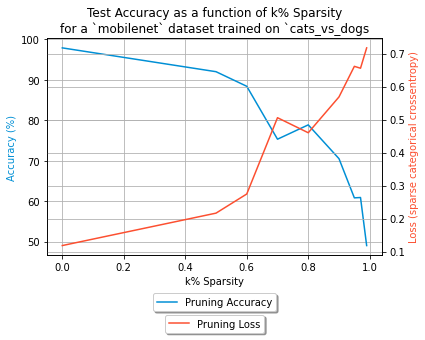

In [58]:
from IPython.core.pylabtools import figsize
# Visualizing performance on MNIST
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
plt.grid(b=None)
ax2 = ax1.twinx()
plt.grid(b=None)
plt.title('Test Accuracy as a function of k% Sparsity\nfor a `mobilenet` dataset trained on `cats_vs_dogs')
ax1.plot(df['sparsity'].values,
         df['val_accuracy'].values,
         '#008fd5', linestyle='-', label='Pruning Accuracy')
ax2.plot(df['sparsity'].values,
         df['val_loss'].values,
         '#fc4f30', linestyle='-', label='Pruning Loss')

ax1.set_ylabel('Accuracy (%)', color='#008fd5')
ax2.set_ylabel('Loss (sparse categorical crossentropy)', color='#fc4f30')
ax1.set_xlabel('k% Sparsity')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2);
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=2);
plt.savefig('Cats vs Dogs_sparsity_comparisons.png')

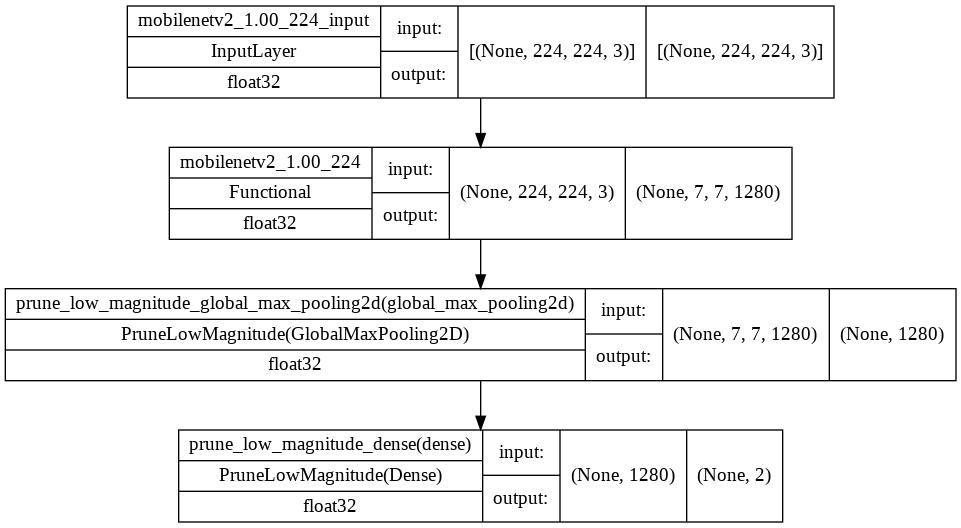

In [59]:
plot_model(pruned_model, to_file="pruned_model.jpeg",show_shapes=True, show_dtype=True)

In [60]:
pruned_model.summary()

Model: "cats_vs_dogs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       4383708   
 ional)                                                          
                                                                 
 prune_low_magnitude_global_  (None, 1280)             1         
 max_pooling2d (PruneLowMagn                                     
 itude)                                                          
                                                                 
 prune_low_magnitude_dense (  (None, 2)                5124      
 PruneLowMagnitude)                                              
                                                                 
Total params: 4,388,833
Trainable params: 1,528,962
Non-trainable params: 2,859,871
_________________________________________________________________


In [61]:
model_1.summary()

Model: "cats_vs_dogs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 1,528,962
Non-trainable params: 731,584
_________________________________________________________________


In [62]:
init_time, avg_time, std = benchmark(val_dir=benchmark_dir,
          model=model_1)
print(f"The first image takes {init_time * 1000:.2f} ms")
print(f"The average time taken per 99 images {avg_time * 1000:.2f} ms")
print(f"The standard deviation of samples is {std * 1000:.2f} ms")

The first image takes 74.40 ms
The average time taken per 99 images 64.78 ms
The standard deviation of samples is 4.47 ms


In [ ]:
feature_extractor.trainable = False

In [64]:
# Load in the best saved model
model_1 = tf.keras.models.load_model("/content/model_experiments/cats_vs_dogs")

In [65]:
logdir, metrics, pruned_model = prune_model(model=model_1,
            initial_sparsity=0,
            final_sparsity=0.5,
            epochs=20)

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


Epoch 1/20
   6/1164 [..............................] - ETA: 1:18 - loss: 0.3846 - accuracy: 0.9688WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0600s vs `on_train_batch_end` time: 0.1734s). Check your callbacks.


1164/1164 [==============================] - 126s 75ms/step - loss: 0.2129 - accuracy: 0.9578 - val_loss: 0.1552 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 2/20
1164/1164 [==============================] - 85s 73ms/step - loss: 0.0956 - accuracy: 0.9710 - val_loss: 0.3426 - val_accuracy: 0.9574 - lr: 0.0010
Epoch 3/20
1164/1164 [==============================] - 85s 73ms/step - loss: 0.1569 - accuracy: 0.9579 - val_loss: 0.5435 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 4/20
1164/1164 [==============================] - 85s 73ms/step - loss: 0.1256 - accuracy: 0.9551 - val_loss: 0.1246 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 5/20
1164/1164 [==============================] - 85s 73ms/step - loss: 0.1228 - accuracy: 0.9554 - val_loss: 0.1929 - val_accuracy: 0.9299 - lr: 0.0010
Epoch 6/20
1164/1164 [==============================] - 90s 77ms/step - loss: 0.1873 - accuracy: 0.9339 - val_loss: 0.4306 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 7/20
1164/1164 [==============================] - 

logdir, metrics, pruned_model = prune_model(model=model_1,
            initial_sparsity=0,
            final_sparsity=0.6,
            epochs=50)

### Pruned model evaluation

In [66]:
pruned_model.evaluate(validation_batches)

291/291 [==============================] - 7s 24ms/step - loss: 0.1777 - accuracy: 0.9319


[0.17771267890930176, 0.9318572878837585]

### Save the pruned model

In [67]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_1)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmpqhhnhrdh.h5


### Save the tflite model

In [68]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmp8co469oj/assets


INFO:tensorflow:Assets written to: /tmp/tmp8co469oj/assets


Saved pruned TFLite model to: /tmp/tmpfntpk_61.tflite


In [82]:
model_1 = tf.keras.models.load_model("/content/model_experiments/cats_vs_dogs")

### Convert orginal model to tflite

In [83]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
orginal_tflite_model = converter.convert()
_, orginal_tflite_file = tempfile.mkstemp('.tflite')

with open(orginal_tflite_file, 'wb') as f:
  f.write(orginal_tflite_model)

print('Saved pruned TFLite model to:', orginal_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpin5225b4/assets


INFO:tensorflow:Assets written to: /tmp/tmpin5225b4/assets


Saved pruned TFLite model to: /tmp/tmp0rj5t3pt.tflite


### Convert pruned model to `Quantized tflite model`

In [69]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpys1rq4gv/assets


INFO:tensorflow:Assets written to: /tmp/tmpys1rq4gv/assets


Saved quantized and pruned TFLite model to: /tmp/tmpllnqso93.tflite


In [33]:
def benchmark_tflite(val_dir, tflite_model, class_names=class_names, image_size=IMG_SIZE):
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  file_count = 0
  infer_times = []
  for (root, dirs, files) in os.walk(val_dir):
    for name in files:
      if name.endswith(".jpg"):
        filename = os.path.join(root, name)
        if file_count < 1 :
          init_timer_start = time.time()
          img = (np.array(Image.open(filename).resize(image_size))/255.0).astype(np.float32)
          img = np.expand_dims(img, axis=0)
          #img = np.expand_dims(img, axis=3)
          interpreter.set_tensor(input_index, img)
          interpreter.invoke()
          output = interpreter.tensor(output_index)
          pred_class = class_names[int(np.argmax(output()[0]))]
          init_timer_end = time.time()
          init_timer = init_timer_end - init_timer_start
          file_count+=1
        else:
          timer_start = time.time()
          img = (np.array(Image.open(filename).resize(image_size))/255.0).astype(np.float32)
          img = np.expand_dims(img, axis=0)
          interpreter.set_tensor(input_index, img)
          interpreter.invoke()
          output = interpreter.tensor(output_index)
          pred_class = class_names[int(np.argmax(output()[0]))]
          timer_end = time.time()
          infer_times.append((timer_end - timer_start))
          file_count+=1

  return init_timer, np.mean(infer_times), np.std(infer_times)

### Benchmark of the orginal model

In [70]:
init_time, avg_time, std = benchmark(val_dir=benchmark_dir,
          model=model_1)
print(f"The first image takes {init_time * 1000:.2f} ms")
print(f"The average time taken per 99 images {avg_time * 1000:.2f} ms")
print(f"The standard deviation of samples is {std * 1000:.2f} ms")

The first image takes 878.53 ms
The average time taken per 99 images 65.33 ms
The standard deviation of samples is 3.76 ms


### Benchmark of the pruned tflite model

In [71]:
init_time, avg_time, std = benchmark_tflite(val_dir=benchmark_dir,
          tflite_model=pruned_tflite_model)
print(f"The first image takes {init_time * 1000:.2f} ms")
print(f"The average time taken per 99 images {avg_time * 1000:.2f} ms")
print(f"The standard deviation of samples is {std * 1000:.2f} ms")

The first image takes 27.52 ms
The average time taken per 99 images 25.68 ms
The standard deviation of samples is 1.69 ms


### Bnechmark quantized pruned model

In [ ]:
init_time, avg_time, std = benchmark_tflite(val_dir=benchmark_dir,
          tflite_model=quantized_and_pruned_tflite_model)
print(f"The first image takes {init_time * 1000:.2f} ms")
print(f"The average time taken per 99 images {avg_time * 1000:.2f} ms")
print(f"The standard deviation of samples is {std * 1000:.2f} ms")

In [73]:
init_time, avg_time, std = benchmark_tflite(val_dir=benchmark_dir,
          tflite_model=orginal_tflite_model)
print(f"The first image takes {init_time * 1000:.2f} ms")
print(f"The average time taken per 99 images {avg_time * 1000:.2f} ms")
print(f"The standard deviation of samples is {std * 1000:.2f} ms")

The first image takes 26.67 ms
The average time taken per 99 images 26.38 ms
The standard deviation of samples is 1.70 ms


### Get details of the pruned tflite model

In [74]:
pruned_tflite_interpreter = tf.lite.Interpreter(model_content=pruned_tflite_model)
pruned_tflite_interpreter.allocate_tensors()

In [75]:
input_details = pruned_tflite_interpreter.get_input_details()
output_details = pruned_tflite_interpreter.get_output_details()

print("INPUT/OUTPUT DETAILS BEFORE RESIZING")
print("Input: ", input_details[0]["shape"])
print("Output: ", output_details[0]["shape"])

INPUT/OUTPUT DETAILS BEFORE RESIZING
Input:  [  1 224 224   3]
Output:  [1 2]


In [77]:
# Resize the inputs and ouputs for batches
pruned_tflite_interpreter.resize_tensor_input(input_details[0]["index"], (BATCH_SIZE, 224, 224, 3))
pruned_tflite_interpreter.resize_tensor_input(output_details[0]["index"], (BATCH_SIZE, num_classes))
pruned_tflite_interpreter.allocate_tensors()

input_details = pruned_tflite_interpreter.get_input_details()
output_details = pruned_tflite_interpreter.get_output_details()

print("INPUT/OUTPUT DETAILS AFTER RESIZING")
print("Input: ", input_details[0]["shape"])
print("Output: ", output_details[0]["shape"])

INPUT/OUTPUT DETAILS AFTER RESIZING
Input:  [ 16 224 224   3]
Output:  [16  2]


In [78]:
#testing_ds = testing_ds.map(normalize_img)
test_image_batch, test_label_batch = next(iter(validation_batches))
print(test_image_batch.shape)

#test_image_batch = np.array(test_image_batch).astype(np.float32)
print(test_image_batch.shape)
print(test_label_batch)


(16, 224, 224, 3)
(16, 224, 224, 3)
tf.Tensor([1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0], shape=(16,), dtype=int64)


### Evaluation function for tflite model


In [79]:
import tqdm
def evaluate_tflite_model(tflite_model, test_data=validation_batches, BATCH_SIZE=BATCH_SIZE):
  toolbar_width = 40
  # Assigne the interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  # Get input output detals
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  # Resize the inputs and ouputs for batches
  # (BATCH_SIZE=32, IMAGE_SHAPE=28, IMAGE_SHAPE=28, CHANNELS=1)
  interpreter.resize_tensor_input(input_details[0]["index"], (BATCH_SIZE, input_details[0]["shape"][1], input_details[0]["shape"][2], input_details[0]["shape"][3]))
  # (BATCH_SIZE=32, NUM_CLASSES=10)
  interpreter.resize_tensor_input(output_details[0]["index"], (BATCH_SIZE, output_details[0]["shape"][1]))
  interpreter.allocate_tensors()

  y_preds = []
  y_true = []
  for batch in tqdm.tqdm(range(len(test_data))):
    time.sleep(0.01)
    image_batch, label_batch = next(iter(test_data))
    # Run inference
    interpreter.set_tensor(input_details[0]["index"], image_batch)
    interpreter.invoke()
    pruned_tflite_pred_probs = interpreter.get_tensor(output_details[0]["index"])
    pruned_tflite_preds = np.argmax(pruned_tflite_pred_probs, axis=1).tolist()
    y_preds += pruned_tflite_preds
    label_batch = np.array(label_batch).tolist()
    y_true +=label_batch

  return accuracy_score(y_true, y_preds)


### Evaluate the orginal tflite model

In [84]:
evaluate_tflite_model(orginal_tflite_model, test_data=validation_batches)

100%|██████████| 291/291 [02:16<00:00,  2.14it/s]


0.875

In [81]:
evaluate_tflite_model(pruned_tflite_model, test_data=validation_batches)

100%|██████████| 291/291 [02:18<00:00,  2.10it/s]


0.875

### Evaluate the quantized tflite model

In [85]:
quantized_model_accuracy = evaluate_tflite_model(quantized_and_pruned_tflite_model, test_data=validation_batches)
quantized_model_accuracy

100%|██████████| 291/291 [1:05:09<00:00, 13.44s/it]


0.875

### Download the quantized model

In [86]:
# Function to rename and download a model
def download_model(model_file, new_name):
  os.rename(model_file, new_name)
  files.download(new_name)

In [87]:
quantized_file_name = "cats_quantized_pruned_model.tflite"
download_model(quantized_and_pruned_tflite_file, quantized_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Download the pruned tflite model

In [88]:
pruned_tflite_file_name = "cats_pruned_tflite_model.tflite"
download_model(pruned_tflite_file, pruned_tflite_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Download th pruned model

In [89]:
pruned_file_name = "cats_pruned_model.h5"
download_model(pruned_keras_file, pruned_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>